In [118]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations 
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score,cross_val_predict,GroupKFold,RandomizedSearchCV,GridSearchCV
from sklearn import metrics  
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import pickle

In [2]:
import warnings 
warnings.filterwarnings("ignore") 

In [412]:
data=pd.read_csv('data_EDA.csv',index_col=0)

In [413]:
pd.set_option('display.max_columns',500)

In [414]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282706 entries, 0 to 2973
Data columns (total 59 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   city                                 282706 non-null  object 
 1   floor                                282706 non-null  int64  
 2   lat                                  282706 non-null  float64
 3   lng                                  282706 non-null  float64
 4   osm_amenity_points_in_0.001          282706 non-null  float64
 5   osm_amenity_points_in_0.005          282706 non-null  float64
 6   osm_amenity_points_in_0.0075         282706 non-null  float64
 7   osm_amenity_points_in_0.01           282706 non-null  float64
 8   osm_building_points_in_0.0075        282706 non-null  float64
 9   osm_building_points_in_0.01          282706 non-null  float64
 10  osm_catering_points_in_0.005         282706 non-null  float64
 11  osm_catering_po

Составляем baseline, чтобы ориентироваться по качеству будущих моделей

## Baseline

In [415]:
X=data[data.label==0].drop(['city','osm_city_nearest_name','region','date','per_square_meter_price','label'],axis=1)
y=data[data.label==0]['per_square_meter_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)
regr=LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
res = metrics.mean_squared_error(y_test, y_pred)
print('MSE:', round(res,4))

MSE: 0.7699


## Feature engineering

Копируем датафрейм в переменную test для тесрирования манипуляций с данными на нем

In [184]:
test=data.copy()

In [185]:
all_cols=data.columns

Создаем функции для определения значимости категориальных и непрерывных переменных по "Mutual information test" и "ANOVA F test" соответственно

In [186]:
def cat_feature_test(col,returned=False):
    imp_cat = pd.Series(mutual_info_regression(test[test.label==0][[col]],
                                                test[test.label==0]['per_square_meter_price'],
                                                discrete_features=True))
    print('Значимость бин. и категор. переменных по Mutual information test')
    print(col,' : ',imp_cat.iloc[0])
    if returned:
        return col, imp_cat.iloc[0]

In [187]:
def num_feature_test(col,returned=False):
    imp_num = pd.Series(f_regression(test[test.label==0][[col]],
                                            test[test.label==0]['per_square_meter_price'])[0])
    print('Значимость непрерывных переменных по ANOVA F test')
    print(col,' : ',imp_num.iloc[0])
    if returned:
        return col, imp_num.iloc[0]

#### city

In [188]:
test['city']=(LabelEncoder().fit_transform(data['city'])).reshape(-1,1)
cat_feature_test('city')

Значимость бин. и категор. переменных по Mutual information test
city  :  0.6446209108124368


Кодируем признак city по частотному методу

In [189]:
fe = data.groupby('city').size()/len(data)
test.loc[:,'city_freq']=data['city'].map(fe)

In [190]:
num_feature_test('city_freq')

Значимость непрерывных переменных по ANOVA F test
city_freq  :  137936.7453786114


In [191]:
fe = data.groupby('city').size()/len(data)
data.loc[:,'city_freq']=data['city'].map(fe)

In [192]:
data.drop('city',axis=1,inplace=True)

#### floor

In [193]:
data[all_cols[1]].value_counts()

0    177487
1    105219
Name: floor, dtype: int64

In [194]:
cat_feature_test('floor')

Значимость бин. и категор. переменных по Mutual information test
floor  :  0.03137815079803419


#### lat

<AxesSubplot:xlabel='lat', ylabel='Density'>

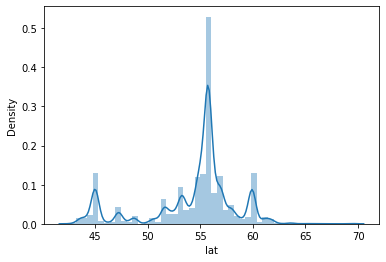

In [195]:
sns.distplot(data[all_cols[2]])

In [196]:
num_feature_test('lat')

Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408446724


Так как распределение не сильно похоже на нормальное нормализуем его методом MinMaxScaler (от 0 до 1)

In [197]:
data.lat=MinMaxScaler().fit_transform(data[['lat']])

#### lng

<AxesSubplot:xlabel='lng', ylabel='Density'>

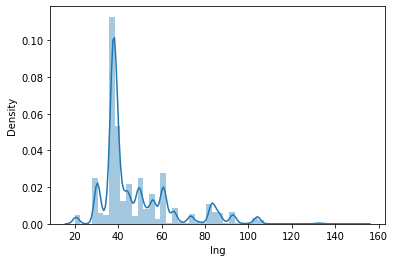

In [198]:
sns.distplot(data[all_cols[3]])

In [199]:
num_feature_test('lng')

Значимость непрерывных переменных по ANOVA F test
lng  :  21653.13162919874


In [200]:
test.lng=np.log(data.lng + 1)

In [201]:
num_feature_test('lng')

Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229444842


<AxesSubplot:xlabel='lng', ylabel='Density'>

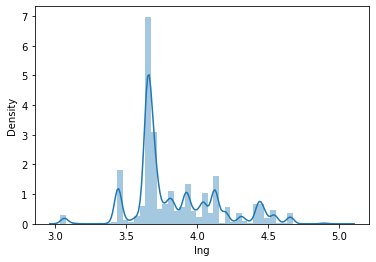

In [202]:
sns.distplot(test[all_cols[3]])

In [203]:
data.lng=np.log(data.lng + 1)
data.lng=MinMaxScaler().fit_transform(data[['lng']])

#### - osm_amenity_points_in_0.001
#### - osm_amenity_points_in_0.005
#### - osm_amenity_points_in_0.0075
#### - osm_amenity_points_in_0.01

<AxesSubplot:>

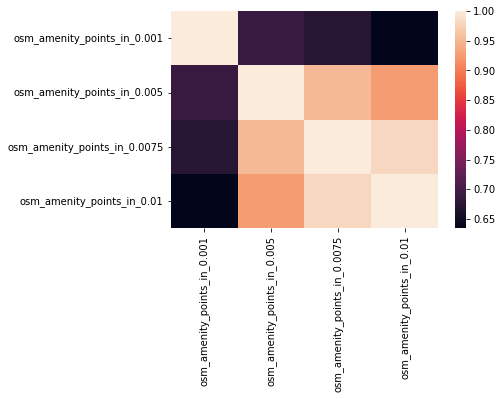

In [204]:
relevant_cols=['osm_amenity_points_in_0.001','osm_amenity_points_in_0.005','osm_amenity_points_in_0.0075','osm_amenity_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.001  :  42995.98185673602


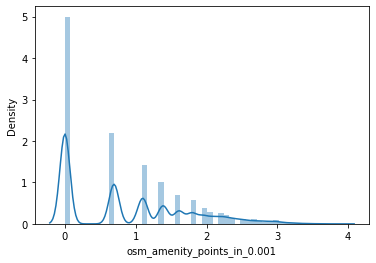

Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.005  :  80184.1026391809


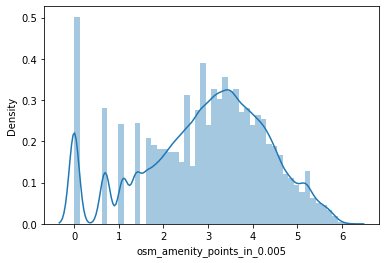

Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.0075  :  91091.32669812934


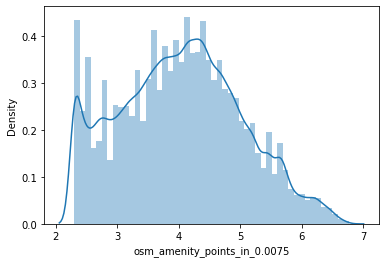

Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  99193.46897676842


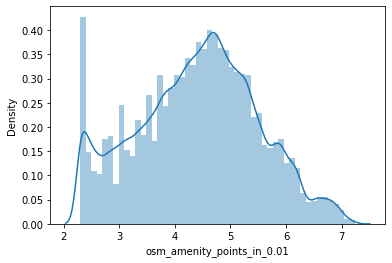

In [205]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

Убираем сильно скоррелированные между собой признаки, которые к тому же имеют похожий смысл, выбираем самый ценный по тесту

In [206]:
data.drop(['osm_amenity_points_in_0.001','osm_amenity_points_in_0.005','osm_amenity_points_in_0.0075'],axis=1,inplace=True)

Так как распределение очень похоже на нормальное кодируем методом StandardScaler

In [207]:
data['osm_amenity_points_in_0.01']=StandardScaler().fit_transform(data[['osm_amenity_points_in_0.01']])

#### - osm_building_points_in_0.0075
#### - osm_building_points_in_0.01

<AxesSubplot:>

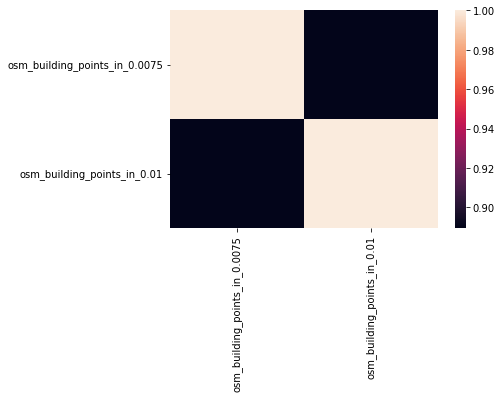

In [208]:
relevant_cols=['osm_building_points_in_0.0075','osm_building_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.0075  :  28591.44568022586


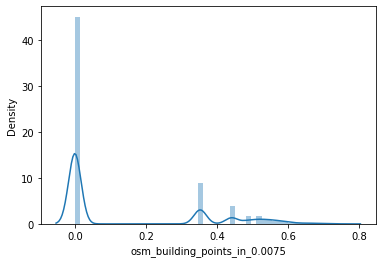

Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  39208.02098910048


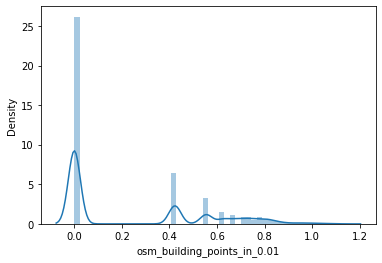

In [209]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [210]:
data.drop(['osm_building_points_in_0.0075'],axis=1,inplace=True)

In [211]:
data['osm_building_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_building_points_in_0.01']])

#### - osm_catering_points_in_0.005
#### - osm_catering_points_in_0.0075
#### - osm_catering_points_in_0.01

In [212]:
data[all_cols[10]]

0       1.098612
1       1.098612
2       1.386294
3       0.000000
4       2.197225
          ...   
2969    0.693147
2970    2.302585
2971    1.098612
2972    3.555348
2973    2.079442
Name: osm_catering_points_in_0.005, Length: 282706, dtype: float64

<AxesSubplot:>

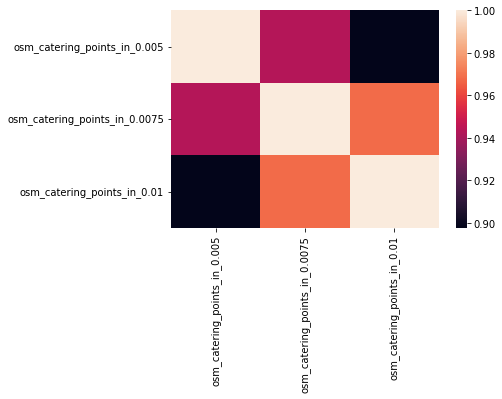

In [213]:
relevant_cols=['osm_catering_points_in_0.005','osm_catering_points_in_0.0075','osm_catering_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  77978.33392442013


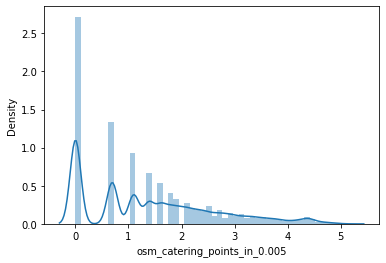

Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.0075  :  90649.8980077013


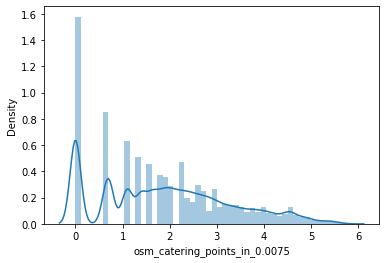

Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.01  :  100735.23575893973


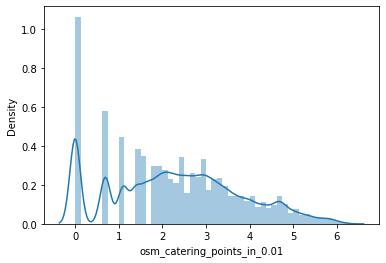

In [214]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [215]:
data.drop(['osm_catering_points_in_0.0075','osm_catering_points_in_0.01'],axis=1,inplace=True)

In [216]:
data['osm_catering_points_in_0.005']=MinMaxScaler().fit_transform(data[['osm_catering_points_in_0.005']])

#### osm_city_closest_dist

In [217]:
data[all_cols[13]]

0       1.120783
1       1.670841
2       1.074806
3       1.467912
4       1.371673
          ...   
2969    1.139067
2970    1.141706
2971    1.066304
2972    0.887208
2973    1.338817
Name: osm_city_closest_dist, Length: 282706, dtype: float64

Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  17859.22593036254


<AxesSubplot:xlabel='osm_city_closest_dist', ylabel='Density'>

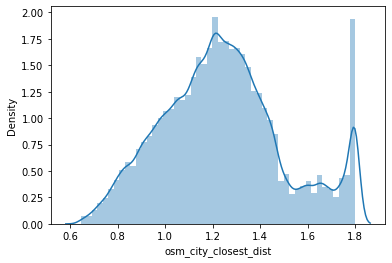

In [218]:
num_feature_test('osm_city_closest_dist')
sns.distplot(test['osm_city_closest_dist'])

In [219]:
data['osm_city_closest_dist']=StandardScaler().fit_transform(data[['osm_city_closest_dist']])

#### osm_city_nearest_name

In [220]:
data[all_cols[14]]

0                 пермь
1         орехово-зуево
2             ярославль
3           новокузнецк
4                 химки
             ...       
2969         красноярск
2970              томск
2971             калуга
2972    нижний новгород
2973    нижний новгород
Name: osm_city_nearest_name, Length: 282706, dtype: object

Также кодируем частотным методом

In [221]:
fe = data.groupby('osm_city_nearest_name').size()/len(data)
test.loc[:,'osm_city_nearest_name_freq']=data['osm_city_nearest_name'].map(fe)

In [222]:
num_feature_test('osm_city_nearest_name_freq')

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  110431.90859553312


In [223]:
fe = data.groupby('osm_city_nearest_name').size()/len(data)
data.loc[:,'osm_city_nearest_name_freq']=data['osm_city_nearest_name'].map(fe)

In [224]:
data.drop('osm_city_nearest_name',axis=1,inplace=True)

#### osm_city_nearest_population

In [225]:
data[all_cols[15]]

0       13.869429
1       11.696788
2       13.311267
3       13.221495
4       12.354781
          ...    
2969    13.906527
2970    13.264947
2971    12.745302
2972    14.040442
2973    14.040442
Name: osm_city_nearest_population, Length: 282706, dtype: float64

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  65856.50204393428


<AxesSubplot:xlabel='osm_city_nearest_population', ylabel='Density'>

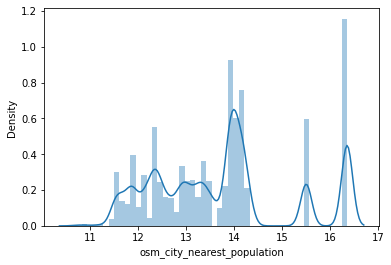

In [226]:
num_feature_test('osm_city_nearest_population')
sns.distplot(test['osm_city_nearest_population'])

#### - osm_crossing_points_in_0.001 
#### - osm_crossing_points_in_0.005 
#### - osm_crossing_points_in_0.0075
#### - osm_crossing_points_in_0.01

In [227]:
data[all_cols[16:20]]

,osm_crossing_points_in_0.001,osm_crossing_points_in_0.005,osm_crossing_points_in_0.0075,osm_crossing_points_in_0.01
0,0.869742,1.945910,2.890372,3.663562
1,0.000000,3.465736,3.931826,4.127134
2,0.000000,2.772589,3.401197,4.060443
3,0.000000,0.000000,0.000000,2.302585
4,0.000000,2.708050,3.713572,4.418841
...,...,...,...,...
2969,0.526589,2.772589,3.806662,4.110874
2970,0.000000,2.639057,3.496508,4.204693
2971,1.162283,3.135494,3.737670,4.406719
2972,0.959135,2.564949,3.135494,3.761200


<AxesSubplot:>

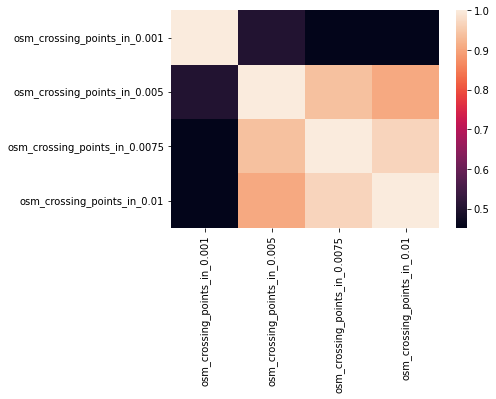

In [228]:
relevant_cols=['osm_crossing_points_in_0.001','osm_crossing_points_in_0.005','osm_crossing_points_in_0.0075','osm_crossing_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.001  :  16889.809034933976


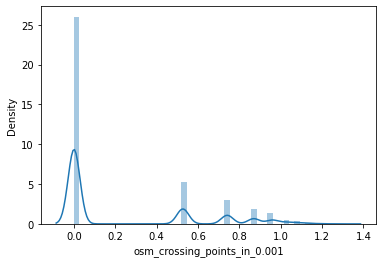

Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.005  :  69276.47234685588


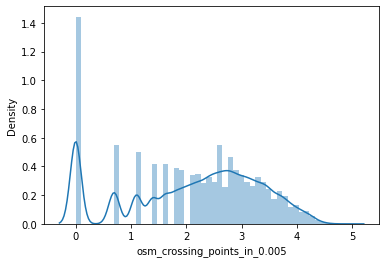

Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.0075  :  84173.98914710054


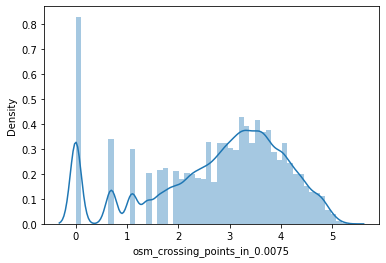

Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941489642


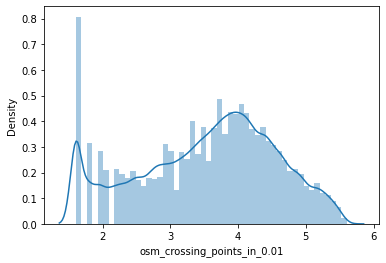

In [229]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [230]:
data.drop(relevant_cols[:3],axis=1,inplace=True)

In [231]:
data['osm_crossing_points_in_0.01']=StandardScaler().fit_transform(data[['osm_crossing_points_in_0.01']])

#### - osm_culture_points_in_0.01

<AxesSubplot:xlabel='osm_culture_points_in_0.01', ylabel='Density'>

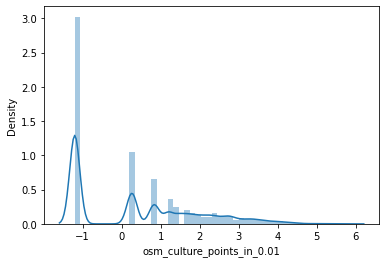

In [232]:
sns.distplot(test['osm_culture_points_in_0.01'])

In [233]:
data['osm_culture_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_culture_points_in_0.01']])

#### - osm_finance_points_in_0.005
#### - osm_finance_points_in_0.0075
#### - osm_finance_points_in_0.01

In [234]:
data[all_cols[21:24]]

,osm_finance_points_in_0.005,osm_finance_points_in_0.0075,osm_finance_points_in_0.01
0,0.000000,0.693147,1.098612
1,0.000000,0.693147,1.098612
2,0.000000,1.791759,2.302585
3,0.000000,0.000000,0.693147
4,0.000000,1.386294,2.302585
...,...,...,...
2969,0.000000,0.000000,0.000000
2970,0.693147,1.386294,2.197225
2971,0.000000,0.000000,1.098612
2972,0.000000,0.693147,0.693147


<AxesSubplot:>

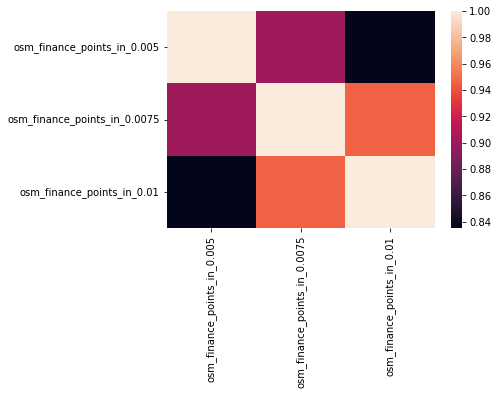

In [235]:
relevant_cols=['osm_finance_points_in_0.005','osm_finance_points_in_0.0075','osm_finance_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  40786.059346170405


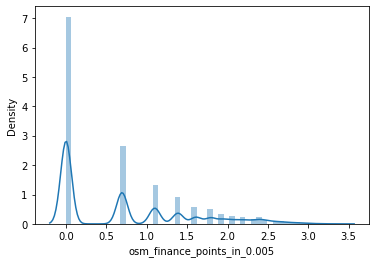

Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.0075  :  50989.324726024744


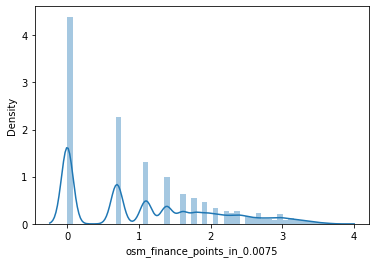

Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.01  :  57931.01798189256


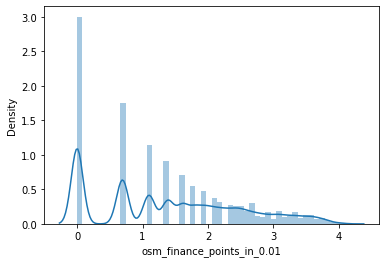

In [236]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [237]:
data.drop(['osm_finance_points_in_0.0075','osm_finance_points_in_0.01'],axis=1,inplace=True)

In [238]:
data['osm_culture_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_culture_points_in_0.01']])

#### - osm_healthcare_points_in_0.005
#### - osm_healthcare_points_in_0.0075	
#### - osm_healthcare_points_in_0.01

In [239]:
data[all_cols[24:27]]

,osm_healthcare_points_in_0.005,osm_healthcare_points_in_0.0075,osm_healthcare_points_in_0.01
0,1.098612,1.386294,1.609438
1,0.693147,0.693147,1.386294
2,0.000000,0.693147,1.386294
3,0.000000,0.000000,1.386294
4,1.098612,2.079442,2.708050
...,...,...,...
2969,0.000000,0.000000,0.000000
2970,0.000000,1.098612,1.609438
2971,1.098612,1.386294,1.609438
2972,0.693147,0.693147,1.098612


<AxesSubplot:>

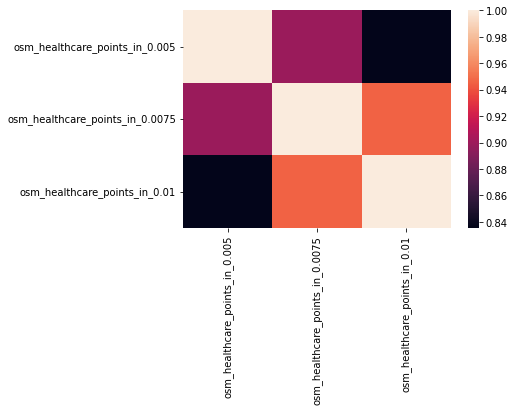

In [240]:
relevant_cols=['osm_healthcare_points_in_0.005','osm_healthcare_points_in_0.0075','osm_healthcare_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.005  :  50901.35014780297


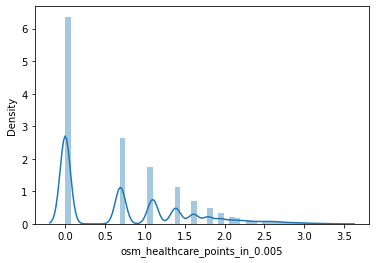

Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.0075  :  69137.32871571729


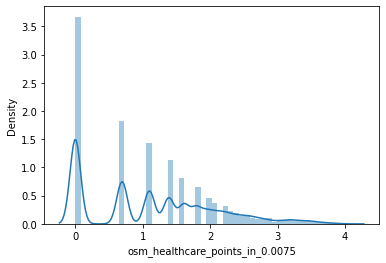

Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699392


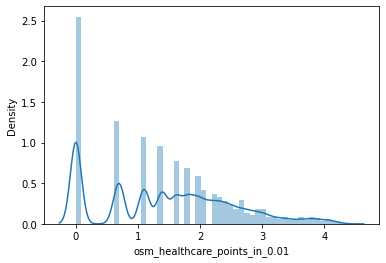

In [241]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [242]:
data.drop(['osm_healthcare_points_in_0.005','osm_healthcare_points_in_0.0075'],axis=1,inplace=True)

In [243]:
data['osm_healthcare_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_healthcare_points_in_0.01']])

#### -	osm_historic_points_in_0.005	
#### -	osm_historic_points_in_0.0075
#### -	osm_historic_points_in_0.01

In [244]:
data[all_cols[27:31]]

,osm_historic_points_in_0.005,osm_historic_points_in_0.0075,osm_historic_points_in_0.01,osm_hotels_points_in_0.01
0,-1.609438,-0.693147,0.693147,-1.609438
1,0.788457,1.504077,1.945910,0.788457
2,-1.609438,-0.693147,0.000000,0.182322
3,-1.609438,-0.693147,0.693147,-1.609438
4,-1.609438,0.916291,1.098612,1.163151
...,...,...,...,...
2969,-1.609438,-0.693147,0.000000,-1.609438
2970,0.182322,0.916291,1.945910,1.824549
2971,1.435085,1.504077,2.079442,-1.609438
2972,1.435085,1.871802,2.484907,1.974081


<AxesSubplot:>

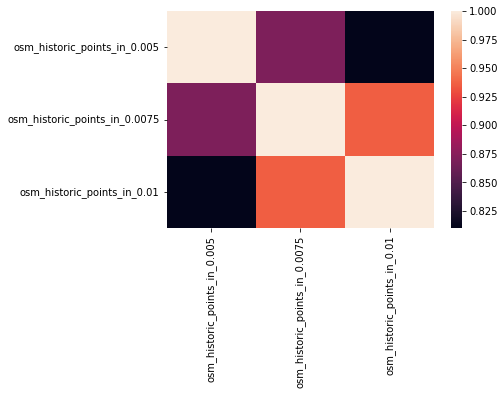

In [245]:
relevant_cols=['osm_historic_points_in_0.005','osm_historic_points_in_0.0075','osm_historic_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.005  :  16937.46492861546


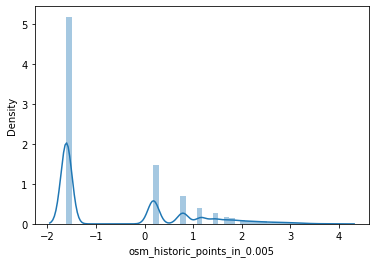

Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.0075  :  28374.824189940682


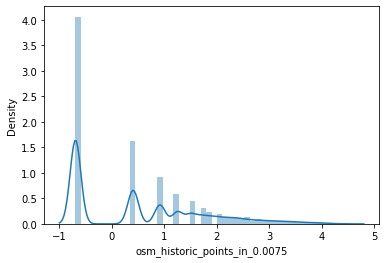

Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  36552.24734661781


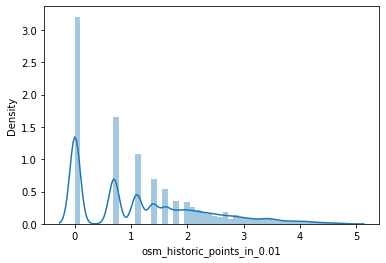

In [246]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [247]:
data.drop(['osm_historic_points_in_0.005','osm_historic_points_in_0.0075'],axis=1,inplace=True)

In [248]:
data['osm_historic_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_historic_points_in_0.01']])

#### osm_hotels_points_in_0.01

<AxesSubplot:xlabel='osm_hotels_points_in_0.01', ylabel='Density'>

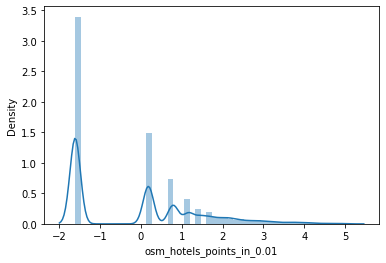

In [249]:
sns.distplot(data[all_cols[30]])

In [250]:
data['osm_hotels_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_hotels_points_in_0.01']])

#### - osm_leisure_points_in_0.005
#### - osm_leisure_points_in_0.0075
#### - osm_leisure_points_in_0.01

In [251]:
data[all_cols[31:34]]

,osm_leisure_points_in_0.005,osm_leisure_points_in_0.0075,osm_leisure_points_in_0.01
0,0.000000,0.693147,1.098612
1,0.693147,0.693147,1.098612
2,1.098612,1.386294,1.945910
3,0.000000,0.000000,0.693147
4,1.386294,1.609438,2.302585
...,...,...,...
2969,0.000000,0.000000,0.000000
2970,0.693147,1.386294,2.708050
2971,0.693147,1.098612,1.386294
2972,2.397895,2.772589,3.044522


<AxesSubplot:>

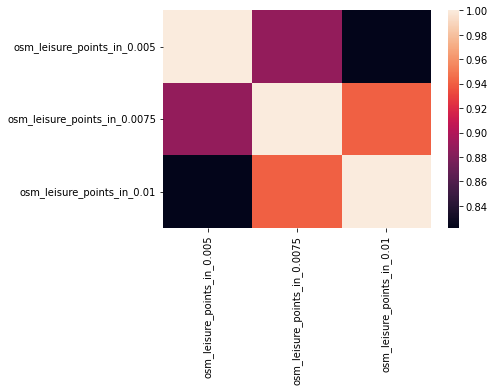

In [252]:
relevant_cols=['osm_leisure_points_in_0.005','osm_leisure_points_in_0.0075','osm_leisure_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.005  :  57403.019566167604


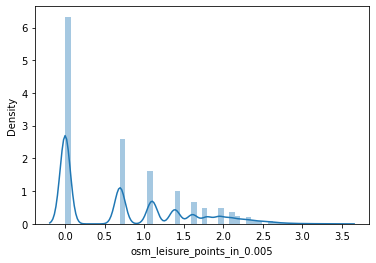

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.0075  :  77973.20279872073


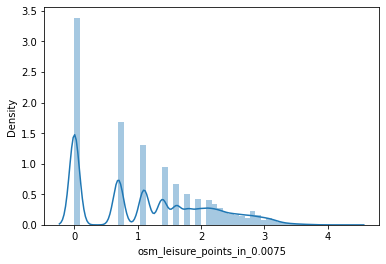

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  94766.11743609192


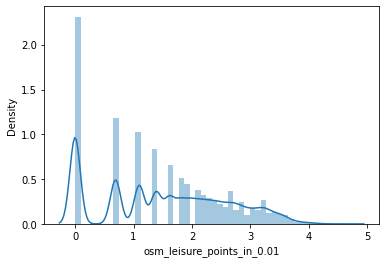

In [253]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [254]:
data.drop(['osm_leisure_points_in_0.005','osm_leisure_points_in_0.0075'],axis=1,inplace=True)

In [255]:
data['osm_leisure_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_leisure_points_in_0.01']])

#### - osm_offices_points_in_0.005	
#### - osm_offices_points_in_0.0075
#### - osm_offices_points_in_0.01

In [256]:
data[all_cols[34:37]]

,osm_offices_points_in_0.005,osm_offices_points_in_0.0075,osm_offices_points_in_0.01
0,0.641854,1.098612,1.609438
1,0.641854,1.098612,1.386294
2,0.641854,1.945910,2.302585
3,-0.105361,0.000000,0.000000
4,2.186051,2.197225,2.564949
...,...,...,...
2969,-0.105361,0.000000,0.693147
2970,-0.105361,0.693147,1.945910
2971,1.589235,1.609438,2.484907
2972,1.774952,2.079442,2.197225


<AxesSubplot:>

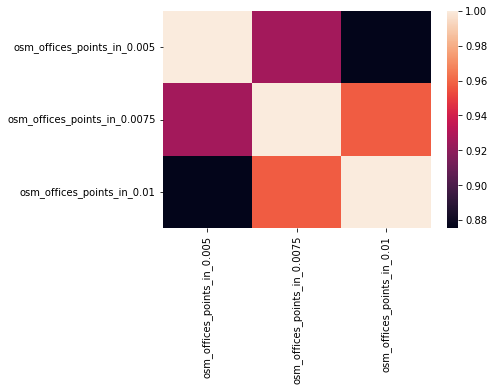

In [257]:
relevant_cols=['osm_offices_points_in_0.005','osm_offices_points_in_0.0075','osm_offices_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.005  :  59586.3067175275


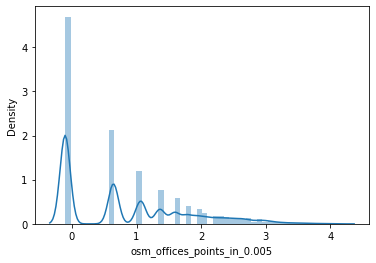

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.0075  :  71556.64110360168


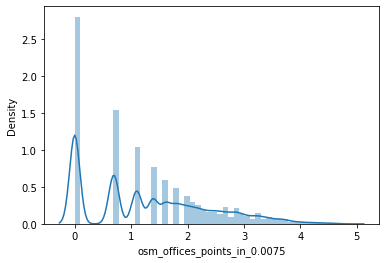

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  82254.12530318343


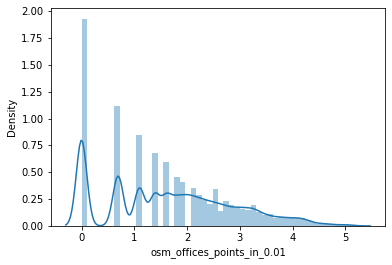

In [258]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [259]:
data.drop(['osm_offices_points_in_0.005','osm_offices_points_in_0.0075'],axis=1,inplace=True)

In [260]:
data['osm_offices_points_in_0.01']=MinMaxScaler().fit_transform(data[['osm_offices_points_in_0.01']])

#### - osm_shops_points_in_0.001	
#### - osm_shops_points_in_0.005
#### - osm_shops_points_in_0.0075	
#### - osm_shops_points_in_0.01

In [261]:
data[all_cols[37:41]]

,osm_shops_points_in_0.001,osm_shops_points_in_0.005,osm_shops_points_in_0.0075,osm_shops_points_in_0.01
0,1.481605,2.484907,3.044522,3.401197
1,0.336472,2.564949,3.044522,3.433987
2,0.336472,2.833213,3.637586,4.406719
3,-0.916291,0.000000,1.609438,2.564949
4,-0.916291,2.197225,3.526361,4.510860
...,...,...,...,...
2969,-0.916291,1.098612,1.791759,2.772589
2970,-0.916291,2.833213,4.219508,4.882802
2971,0.336472,2.995732,3.737670,4.343805
2972,0.336472,2.708050,3.526361,3.891820


<AxesSubplot:>

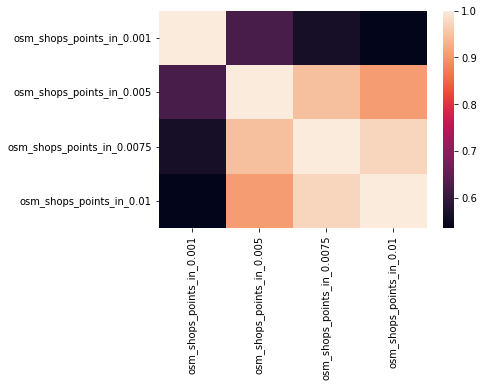

In [262]:
relevant_cols=['osm_shops_points_in_0.001','osm_shops_points_in_0.005','osm_shops_points_in_0.0075','osm_shops_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_shops_points_in_0.001  :  31913.904368021256


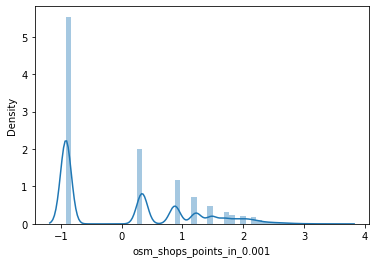

Значимость непрерывных переменных по ANOVA F test
osm_shops_points_in_0.005  :  71331.80261971777


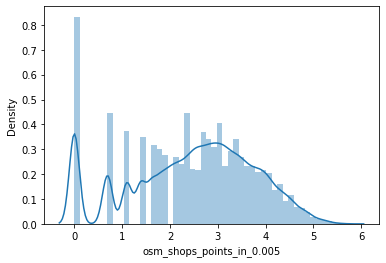

Значимость непрерывных переменных по ANOVA F test
osm_shops_points_in_0.0075  :  81899.4374938732


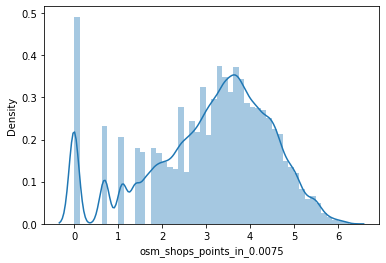

Значимость непрерывных переменных по ANOVA F test
osm_shops_points_in_0.01  :  91570.55626330954


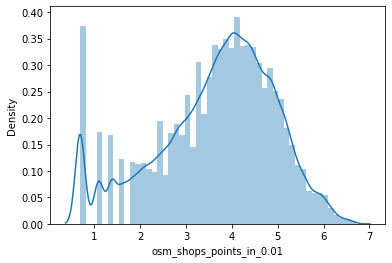

In [263]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [264]:
data.drop(['osm_shops_points_in_0.001','osm_shops_points_in_0.005','osm_shops_points_in_0.0075'],axis=1,inplace=True)

In [265]:
data['osm_shops_points_in_0.01']=StandardScaler().fit_transform(data[['osm_shops_points_in_0.01']])

#### osm_subway_closest_dist

In [266]:
data[all_cols[41]]

0       5.598514
1       4.639141
2       5.498650
3       5.692497
4       0.746891
          ...   
2969    1.595550
2970    5.311571
2971    4.950490
2972    0.977354
2973    1.136214
Name: osm_subway_closest_dist, Length: 282706, dtype: float64

<AxesSubplot:xlabel='osm_subway_closest_dist', ylabel='Density'>

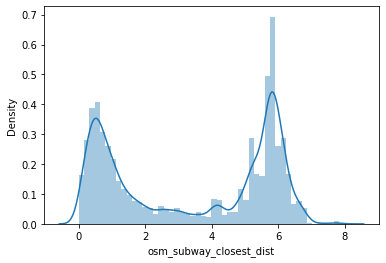

In [267]:
sns.distplot(data['osm_subway_closest_dist'])

In [268]:
data['osm_subway_closest_dist']=MinMaxScaler().fit_transform(data[['osm_subway_closest_dist']])

#### osm_train_stop_closest_dist

In [269]:
data[all_cols[42]]

0       0.705270
1       0.376302
2       0.370307
3       1.061910
4       0.303407
          ...   
2969    0.647177
2970    0.174380
2971    1.104421
2972    0.603051
2973    0.224782
Name: osm_train_stop_closest_dist, Length: 282706, dtype: float64

<AxesSubplot:xlabel='osm_train_stop_closest_dist', ylabel='Density'>

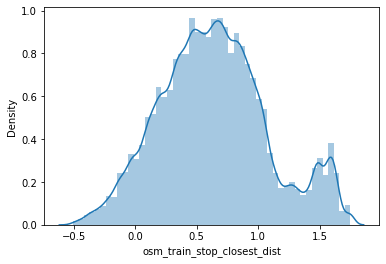

In [270]:
sns.distplot(data['osm_train_stop_closest_dist'])

In [271]:
data['osm_train_stop_closest_dist']=StandardScaler().fit_transform(data[['osm_train_stop_closest_dist']])

#### - osm_transport_stop_points_in_0.005	
#### - osm_transport_stop_points_in_0.0075
#### - osm_transport_stop_points_in_0.01

In [272]:
data[all_cols[43:46]]

,osm_transport_stop_points_in_0.005,osm_transport_stop_points_in_0.0075,osm_transport_stop_points_in_0.01
0,1.609438,2.639057,3.258097
1,1.609438,2.397895,2.772589
2,2.302585,2.639057,3.258097
3,0.000000,0.000000,2.079442
4,2.397895,3.496508,4.204693
...,...,...,...
2969,1.945910,2.302585,2.995732
2970,1.791759,3.044522,3.737670
2971,2.079442,2.833213,3.465736
2972,2.079442,2.397895,3.178054


<AxesSubplot:>

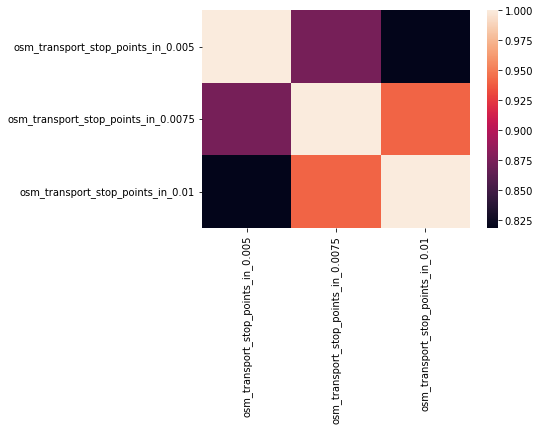

In [273]:
relevant_cols=['osm_transport_stop_points_in_0.005','osm_transport_stop_points_in_0.0075','osm_transport_stop_points_in_0.01']
sns.heatmap(data[relevant_cols].corr())

Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.005  :  58629.26602587701


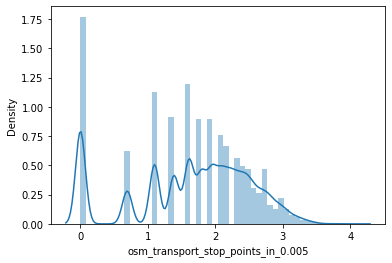

Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.0075  :  79869.45247679728


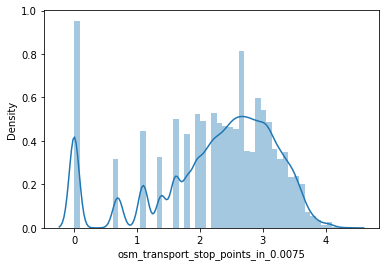

Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  98476.96304714552


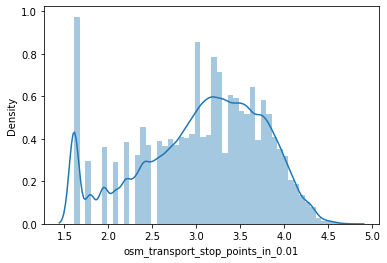

In [274]:
for col in relevant_cols:
    num_feature_test(col)
    sns.distplot(test[col])
    plt.show()

In [275]:
data.drop(['osm_transport_stop_points_in_0.005','osm_transport_stop_points_in_0.0075'],axis=1,inplace=True)

In [276]:
data['osm_transport_stop_points_in_0.01']=StandardScaler().fit_transform(data[['osm_transport_stop_points_in_0.01']])

#### per_square_meter_price

In [277]:
data[all_cols[46]]

0       11.848958
1       11.008938
2       10.718095
3       10.268348
4        9.489758
          ...    
2969          NaN
2970          NaN
2971          NaN
2972          NaN
2973          NaN
Name: per_square_meter_price, Length: 282706, dtype: float64

<AxesSubplot:xlabel='per_square_meter_price', ylabel='Density'>

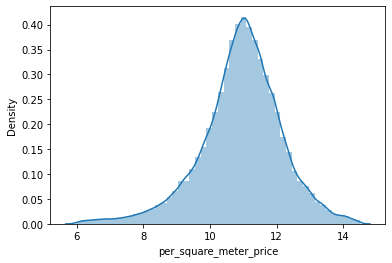

In [278]:
sns.distplot(data['per_square_meter_price'])

In [443]:
price_scaler=StandardScaler()
data['per_square_meter_price']=price_scaler.fit_transform(data[['per_square_meter_price']])

#### reform_count_of_houses_1000

In [280]:
data[all_cols[47]]

0       4.941642
1       5.010635
2       4.691348
3       4.369448
4       4.997212
          ...   
2969    4.043051
2970    5.308268
2971    4.875197
2972    5.313206
2973    4.927254
Name: reform_count_of_houses_1000, Length: 282706, dtype: float64

<AxesSubplot:xlabel='reform_count_of_houses_1000', ylabel='Density'>

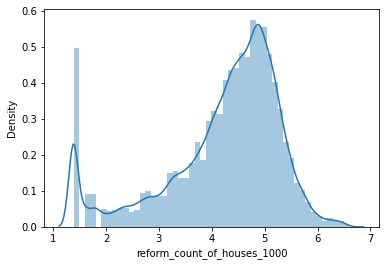

In [281]:
sns.distplot(data['reform_count_of_houses_1000'])

In [282]:
data['reform_count_of_houses_1000']=StandardScaler().fit_transform(data[['reform_count_of_houses_1000']])

#### reform_count_of_houses_500

In [283]:
data[all_cols[48]]

0       3.931826
1       3.663562
2       3.367296
3       1.386294
4       3.688879
          ...   
2969    2.639057
2970    4.158883
2971    3.178054
2972    3.688879
2973    3.951244
Name: reform_count_of_houses_500, Length: 282706, dtype: float64

<AxesSubplot:xlabel='reform_count_of_houses_500', ylabel='Density'>

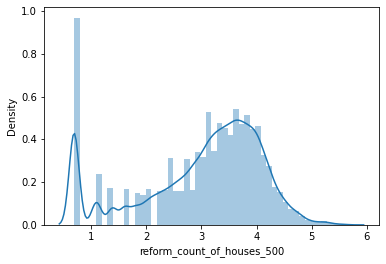

In [284]:
sns.distplot(data['reform_count_of_houses_500'])

In [285]:
data['reform_count_of_houses_500']=StandardScaler().fit_transform(data[['reform_count_of_houses_500']])

#### reform_house_population_1000

In [286]:
data[all_cols[49]]

0       7.864420
1       7.269617
2       7.592366
3       7.550135
4       8.067776
          ...   
2969    7.078342
2970    8.041735
2971    7.369601
2972    7.274480
2973    8.016978
Name: reform_house_population_1000, Length: 282706, dtype: float64

<AxesSubplot:xlabel='reform_house_population_1000', ylabel='Density'>

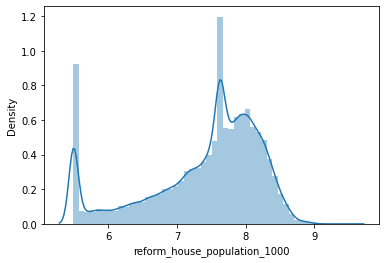

In [287]:
sns.distplot(data['reform_house_population_1000'])

In [288]:
data['reform_house_population_1000']=StandardScaler().fit_transform(data[['reform_house_population_1000']])

#### reform_house_population_500

In [289]:
data[all_cols[50]]

0       6.762730
1       6.419995
2       6.511745
3       5.036953
4       6.577861
          ...   
2969    5.828946
2970    6.983790
2971    6.028279
2972    6.152733
2973    6.949856
Name: reform_house_population_500, Length: 282706, dtype: float64

<AxesSubplot:xlabel='reform_house_population_500', ylabel='Density'>

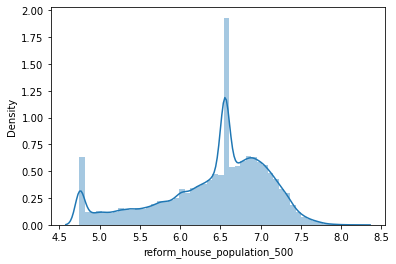

In [290]:
sns.distplot(data['reform_house_population_500'])

In [291]:
data['reform_house_population_500']=StandardScaler().fit_transform(data[['reform_house_population_500']])

#### reform_mean_floor_count_1000

In [292]:
data[all_cols[51]]

0       1.911461
1       1.359531
2       1.965911
3       2.259790
4       2.111895
          ...   
2969    1.906689
2970    1.904237
2971    1.606207
2972    1.574695
2973    2.074585
Name: reform_mean_floor_count_1000, Length: 282706, dtype: float64

<AxesSubplot:xlabel='reform_mean_floor_count_1000', ylabel='Density'>

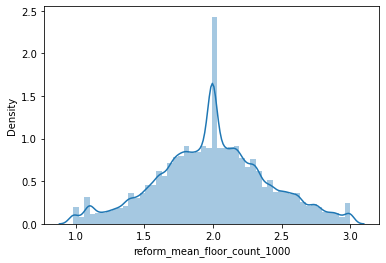

In [293]:
sns.distplot(data['reform_mean_floor_count_1000'])

In [294]:
data['reform_mean_floor_count_1000']=StandardScaler().fit_transform(data[['reform_mean_floor_count_1000']])

#### reform_mean_floor_count_500

In [295]:
data[all_cols[52]]

0       1.876501
1       1.510231
2       2.106841
3       2.302585
4       1.899748
          ...   
2969    1.992430
2970    1.928961
2971    1.776492
2972    1.710081
2973    1.862529
Name: reform_mean_floor_count_500, Length: 282706, dtype: float64

<AxesSubplot:xlabel='reform_mean_floor_count_500', ylabel='Density'>

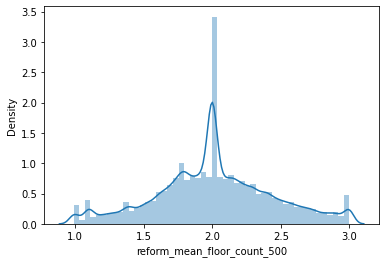

In [296]:
sns.distplot(data['reform_mean_floor_count_500'])

In [297]:
data['reform_mean_floor_count_500']=StandardScaler().fit_transform(data[['reform_mean_floor_count_500']])

#### region

In [298]:
data[all_cols[53]]

0               пермский край
1          московская область
2         ярославская область
3         кемеровская область
4                      москва
                ...          
2969        красноярский край
2970          томская область
2971        калужская область
2972    нижегородская область
2973    нижегородская область
Name: region, Length: 282706, dtype: object

In [299]:
fe = data.groupby('region').size()/len(data)
test.loc[:,'region_freq']=data['region'].map(fe)

In [300]:
num_feature_test('region_freq')

Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.2232420564


In [301]:
fe = data.groupby('region').size()/len(data)
data.loc[:,'region_freq']=data['region'].map(fe)

In [302]:
data.drop(['region'],axis=1,inplace=True)

#### total_square

In [303]:
data[all_cols[54]]

0       1.279963
1       1.747173
2       1.757588
3       1.677521
4       1.438447
          ...   
2969    2.050718
2970    1.789613
2971    1.523143
2972    1.694757
2973    1.714069
Name: total_square, Length: 282706, dtype: float64

<AxesSubplot:xlabel='total_square', ylabel='Density'>

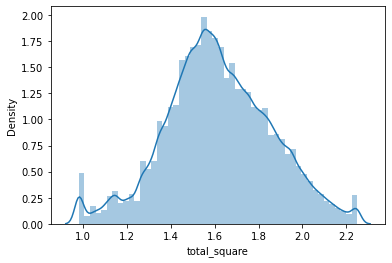

In [304]:
sns.distplot(data['total_square'])

In [305]:
num_feature_test('total_square')

Значимость непрерывных переменных по ANOVA F test
total_square  :  5041.829592242761


In [306]:
data['total_square']=StandardScaler().fit_transform(data[['total_square']])

#### date

In [307]:
data[all_cols[55]]

0       2020-01-05
1       2020-01-05
2       2020-01-05
3       2020-01-05
4       2020-01-05
           ...    
2969    2020-12-27
2970    2020-12-27
2971    2020-12-27
2972    2020-12-27
2973    2020-12-27
Name: date, Length: 282706, dtype: object

In [308]:
data.date=pd.to_datetime(data.date,format='%Y-%m-%d')

In [309]:
data.loc[:,'month']=data.date.dt.month

<AxesSubplot:xlabel='month', ylabel='Density'>

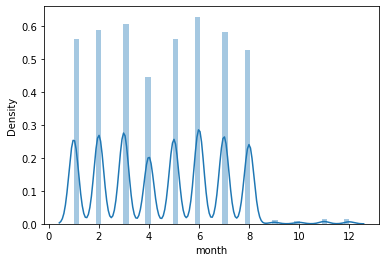

In [310]:
sns.distplot(data['month'])

In [311]:
data['month']=StandardScaler().fit_transform(data[['month']])

In [312]:
data.loc[:,'day']=data.date.dt.day

<AxesSubplot:xlabel='day', ylabel='Density'>

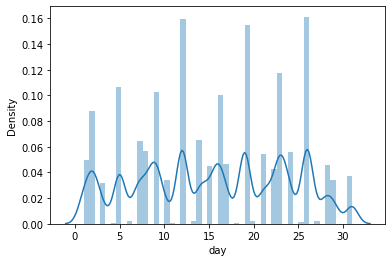

In [313]:
sns.distplot(data['day'])

In [314]:
data['day']=StandardScaler().fit_transform(data[['day']])

In [315]:
data.drop('date',axis=1,inplace=True)

#### realty_type

In [316]:
data[all_cols[56]].value_counts()

10     149669
110     74812
100     58225
Name: realty_type, dtype: int64

Применяем для признака one-hot кодирование

In [317]:
data=pd.concat([data,pd.get_dummies(data['realty_type'],prefix='realty_type')],axis=1)

In [318]:
data.drop(['realty_type'],axis=1,inplace=True)

#### price_type

In [319]:
data[all_cols[57]].value_counts()

0    275240
1      7466
Name: price_type, dtype: int64

In [320]:
test=data.copy()

Убираем сильно скоррелированные между собой признаки ориенируясь на значимость каждого

In [322]:
corr_matrix=data.corr()

column_list = corr_matrix.columns.values.tolist() 
result = pd.DataFrame(columns=['feature_1','feature_2','corr_coef']) 
for c in combinations(column_list, 2): 
    new_line={'feature_1':c[0],'feature_2':c[1],'corr_coef':corr_matrix[c[0]][c[1]],
              'feature_1_test':num_feature_test(c[0],returned=True)[1],'feature_2_test':num_feature_test(c[1],returned=True)[1]}
    result=pd.concat([result,pd.DataFrame(pd.Series(new_line)).T],axis=0)

Значимость непрерывных переменных по ANOVA F test
floor  :  16002.728115016569
Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408444338
Значимость непрерывных переменных по ANOVA F test
floor  :  16002.728115016569
Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229453053
Значимость непрерывных переменных по ANOVA F test
floor  :  16002.728115016569
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  99193.46897677395
Значимость непрерывных переменных по ANOVA F test
floor  :  16002.728115016569
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  39208.02098909978
Значимость непрерывных переменных по ANOVA F test
floor  :  16002.728115016569
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  77978.33392442198
Значимость непрерывных переменных по ANOVA F test
floor  :  16002.728115016569
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  

Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408444338
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  94766.11743609523
Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408444338
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  82254.12530318603
Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408444338
Значимость непрерывных переменных по ANOVA F test
osm_shops_points_in_0.01  :  91570.55626330448
Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408444338
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  98311.76032557
Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408444338
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  46024.81587021201
Значимость непрерывных переменных по ANOVA F test
lat  :  6917.991408444338
Значимость непрерывных переменных по ANOVA F test
osm_tr

Значимость непрерывных переменных по ANOVA F test
price_type  :  2.8040025358447282
Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229453053
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229453053
Значимость непрерывных переменных по ANOVA F test
city_freq  :  137936.74537861088
Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229453053
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  110431.90859553244
Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229453053
Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.22324205535
Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229453053
Значимость непрерывных переменных по ANOVA F test
month  :  35.836780802623
Значимость непрерывных переменных по ANOVA F test
lng  :  25498.749229453053
Значимость непрерывных переменных по ANOVA F t

Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  39208.02098909978
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941488506
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  39208.02098909978
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01  :  45112.471063376564
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  39208.02098909978
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  40786.05934617005
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  39208.02098909978
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699668
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  39208.02098909978
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  36552.2473466194

Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  46024.81587021201
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  77978.33392442198
Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  98476.96304714268
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  77978.33392442198
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  77978.33392442198
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  22079.722724910844
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  77978.33392442198
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_500  :  11929.068421817208
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  77978.33392442198
Значимо

Значимость непрерывных переменных по ANOVA F test
month  :  35.836780802623
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  17859.225930362656
Значимость непрерывных переменных по ANOVA F test
day  :  53.135096293270536
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  17859.225930362656
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8140.354297052133
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  17859.225930362656
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2917.6890895524293
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  17859.225930362656
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  2668.5687779334926
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  65856.50204392782
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941488506
Зн

Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941488506
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941488506
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  22079.722724910844
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941488506
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_500  :  11929.068421817208
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941488506
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  34558.495449505936
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  92215.04941488506
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  16869.143987871386
Значимость непр

Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2917.6890895524293
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01  :  45112.471063376564
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  2668.5687779334926
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  40786.05934617005
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699668
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  40786.05934617005
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  36552.24734661946
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  40786.05934617005
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  43448.506529179234
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  40786.05934617005
Значимость непрерывны

Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699668
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699668
Значимость непрерывных переменных по ANOVA F test
total_square  :  5041.8295922438565
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699668
Значимость непрерывных переменных по ANOVA F test
price_type  :  2.8040025358447282
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699668
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  83237.75642699668
Значимость непрерывных переменных по ANOVA F test
city_freq  :  137936.74537861088
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_

Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  43448.506529179234
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  34558.495449505936
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  43448.506529179234
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  16869.143987871386
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  43448.506529179234
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  41627.12479934997
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  43448.506529179234
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  43448.506529179234
Значимость непрерывных переменных по ANOVA F test
total_square  :  5041.8295922438565
Значимость неп

Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  34558.495449505936
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  82254.12530318603
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  16869.143987871386
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  82254.12530318603
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  41627.12479934997
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  82254.12530318603
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  82254.12530318603
Значимость непрерывных переменных по ANOVA F test
total_square  :  5041.8295922438565
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  82254.12530318603
Значимость неп

osm_subway_closest_dist  :  98311.76032557
Значимость непрерывных переменных по ANOVA F test
price_type  :  2.8040025358447282
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  98311.76032557
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  98311.76032557
Значимость непрерывных переменных по ANOVA F test
city_freq  :  137936.74537861088
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  98311.76032557
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  110431.90859553244
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  98311.76032557
Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.22324205535
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  98311.76032557
Значимость непрерывных переменных по ANOVA F test
month  :  35.836780802623


Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  2668.5687779334926
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  22079.722724910844
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_500  :  11929.068421817208
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  34558.495449505936
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  16869.143987871386
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  41627.12479934997
З

Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_500  :  11929.068421817208
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2917.6890895524293
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_500  :  11929.068421817208
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  2668.5687779334926
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  34558.495449505936
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  16869.143987871386
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  34558.495449505936
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  41627.12479934997
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  34558.495449505936
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость не

Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
city_freq  :  137936.74537861088
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  110431.90859553244
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.22324205535
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
month  :  35.836780802623
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  27857.165263973733
Значимость непрерывных переменных по ANOVA F test
day  :  53.135096293270536
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_

Значимость непрерывных переменных по ANOVA F test
month  :  35.836780802623
Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.22324205535
Значимость непрерывных переменных по ANOVA F test
day  :  53.135096293270536
Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.22324205535
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8140.354297052133
Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.22324205535
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2917.6890895524293
Значимость непрерывных переменных по ANOVA F test
region_freq  :  129415.22324205535
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  2668.5687779334926
Значимость непрерывных переменных по ANOVA F test
month  :  35.836780802623
Значимость непрерывных переменных по ANOVA F test
day  :  53.135096293270536
Значимость непрерывных переменных по ANOVA F test
month  :  35.836780802623
Значимость не

In [323]:
result.reset_index(drop=True,inplace=True)
res=result[(result.corr_coef<-0.9) | (result.corr_coef>0.9)]

In [324]:
cols_to_drop=[]
for i in range(len(res)):
    if res.iloc[i]['feature_1_test']>res.iloc[i]['feature_2_test']:
        cols_to_drop.append(res.iloc[i]['feature_2'])
    elif res.iloc[i]['feature_1_test']<res.iloc[i]['feature_2_test']:
        cols_to_drop.append(res.iloc[i]['feature_1'])

In [325]:
res

,feature_1,feature_2,corr_coef,feature_1_test,feature_2_test
120,osm_amenity_points_in_0.01,osm_shops_points_in_0.01,0.972872,99193.468977,91570.556263
567,reform_count_of_houses_1000,reform_count_of_houses_500,0.905571,22079.722725,11929.068422
676,city_freq,region_freq,0.964664,137936.745379,129415.223242


In [326]:
cols_to_drop=list(set(cols_to_drop))

In [327]:
cols_to_drop

['reform_count_of_houses_500', 'osm_shops_points_in_0.01', 'region_freq']

In [ ]:
data.drop(cols_to_drop,axis=1,inplace=True)

In [328]:
np.abs(data.corr()['per_square_meter_price']).sort_values()

price_type                           0.003166
month                                0.011318
day                                  0.013781
realty_type_110                      0.097209
realty_type_100                      0.101601
total_square                         0.133059
lat                                  0.155352
realty_type_10                       0.168160
reform_count_of_houses_500           0.202239
floor                                0.232620
reform_house_population_500          0.238485
osm_city_closest_dist                0.244976
reform_count_of_houses_1000          0.270477
lng                                  0.289033
reform_mean_floor_count_500          0.300943
reform_house_population_1000         0.331599
osm_historic_points_in_0.01          0.339954
osm_building_points_in_0.01          0.350618
osm_finance_points_in_0.005          0.356723
reform_mean_floor_count_1000         0.359910
osm_hotels_points_in_0.01            0.366662
osm_culture_points_in_0.01        

Из-за сильной несбалансированности классов price_type, строки со значением 1 доводим до такого же количества, что и со значением 0

In [329]:
for i in range(6):
    data=pd.concat([data,data[(data.label==0) & (data.price_type==1)]])

In [330]:
data.price_type.value_counts()

1    290462
0    275240
Name: price_type, dtype: int64

In [331]:
corr_mask=~pd.isnull(data.corr()[(data.corr()>0.9) & (data.corr()!=1)].dropna(axis=1,how='all').dropna(axis=0,how='all'))

Оцениваем качество после проделанных манипуляций

In [332]:
from sklearn.model_selection import train_test_split
X=data[data.label==0].drop(['label','per_square_meter_price'],axis=1)
y=data[data.label==0]['per_square_meter_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

from sklearn import metrics  
regr=LinearRegression()


regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
res = metrics.mean_squared_error(y_test, y_pred)
print('MSE:', round(res,4))

MSE: 0.303


Создадим полиномиальные признаки

In [ ]:
best_comb = []
for comb in list(combinations(data.columns, 2)):
    comb = list(comb)
    if 'per_square_meter_price' not in comb:
        pf = PolynomialFeatures(2)
        poly = pd.DataFrame(pf.fit_transform(data[data['label'] == 0][comb]))
        res = pd.concat([data[data['label'] == 0].reset_index(), poly.iloc[:, :]],
                        axis=1).corr()['per_square_meter_price'].iloc[-2]
        if res > 0.4:
            best_comb.append(comb)

In [ ]:
best_comb.to_csv('best_comb.csv')

In [336]:
best_comb=pd.read_csv('best_comb.csv')

In [ ]:
for comb in best_comb['combs']:
    comb=comb[2:-2].split("', '")
    if 'per_square_meter_price' not in comb:
        pf = PolynomialFeatures(2)
        poly = pd.DataFrame(pf.fit_transform(test[comb]),columns=[f'{comb[0]}_{comb[1]}']*6)
        if abs(pd.concat([data[data['label'] == 0].reset_index(drop=True), poly.iloc[:, :]],
                        axis=1).corr()['per_square_meter_price'].iloc[-2]) > 0.4:

            data = pd.concat([data.reset_index(drop=True), poly.iloc[:, [-2]]], axis=1)

Еще раз убираем сильную корреляцию

In [363]:
corr_matrix=data.corr()

column_list = corr_matrix.columns.values.tolist() 
result = pd.DataFrame(columns=['feature_1','feature_2','corr_coef']) 
for c in combinations(column_list, 2): 
    new_line={'feature_1':c[0],'feature_2':c[1],'corr_coef':corr_matrix[c[0]][c[1]],
              'feature_1_test':num_feature_test(c[0],returned=True)[1],'feature_2_test':num_feature_test(c[1],returned=True)[1]}
    result=pd.concat([result,pd.DataFrame(pd.Series(new_line)).T],axis=0)

Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
lat  :  13627.142439017998
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21

Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_region_freq  :  195345.7336572895
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_osm_city_nearest_name_freq  :  236624.8378613224
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  :  249677.66660726472
Значимость непрерывных переменных по ANOVA F test
floor  :  16648.81316021556
Значимость непрерывных перемен

Значимость непрерывных переменных по ANOVA F test
day  :  28.893853500071152
Значимость непрерывных переменных по ANOVA F test
lat  :  13627.142439017998
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
lat  :  13627.142439017998
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
lat  :  13627.142439017998
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3199.113986397916
Значимость непрерывных переменных по ANOVA F test
lat  :  13627.142439017998
Значимость непрерывных переменных по ANOVA F test
lat_city_freq  :  256248.81792463525
Значимость непрерывных переменных по ANOVA F test
lat  :  13627.142439017998
Значимость непрерывных переменных по ANOVA F test
lat_osm_city_nearest_name_freq  :  231828.003966482
Значимость непрерывных переменных по ANOVA F test
lat  :  13627.142439017998
Значимость 

Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  139813.53788649733
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  150621.63827016938
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  74166.72151110892
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  166404.500627139
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
reform_coun

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
lng  :  20811.29756737631
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по ANOVA 

Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_city_freq  :  248595.48699394008
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_region_freq  :  221291.9790598016
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
osm_amenity_points_in_0.01  :  162000.88936422675
Значимость непрерывных переменных по AN

Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
total_square  :  14164.495726089492
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
price_type  :  145.76187612102703
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
osm_building_po

Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01  :  70629.19072878521
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21167.42106111508
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  144394.683041322
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.738340

Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_region_freq  :  224638.8896288528
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_region_freq  :  195345.7336572895
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005  :  136793.7383401313
Значимость непрерывных переменных по ANOVA F test
o

Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21167.42106111508
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21167.42106111508
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21167.42106111508
Значимость непрерывных переменных по ANOVA F test
day  :  28.893853500071152
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21167.42106111508
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21167.42106111508
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_city_closest_dist  :  21167.42106111508
Значимо

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  146768.80881403276
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  139813.53788649733
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  150621.63827016938
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  74166.72151110892
З

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_region_freq  :  203743.18617498945
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01_city_freq  :  212712.60299160602
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_city_freq  :  245127.3756234682
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population  :  146970.87398267162
Значимость непрерывных переменных по 

Значимость непрерывных переменных по ANOVA F test
lng_region_freq  :  159573.39734925516
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  144394.683041322
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01_city_freq  :  183923.53344139145
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  144394.683041322
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_city_freq  :  260008.46885932575
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  144394.683041322
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
osm_crossing_points_in_0.01  :  144394.683041322
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_city_freq  :  248595.48699394008
Значимость непрерывных переменных по ANOVA F test
osm_crossing_point

Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01  :  71221.68184329958
Значимость непрерывных переменных по ANOVA F test
total_square  :  14164.495726089492
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01  :  71221.68184329958
Значимость непрерывных переменных по ANOVA F test
price_type  :  145.76187612102703
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01  :  71221.68184329958
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01  :  71221.68184329958
Значимость непрерывных переменных по ANOVA F test
city_freq  :  237397.2733203292
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01  :  71221.68184329958
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.

Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  142758.2970210479
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  61511.33479471742
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  146768.80881403276
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  139813.53788649733
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
З

Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_region_freq  :  203743.18617498945
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01_city_freq  :  212712.60299160602
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_city_freq  :  245127.3756234682
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005  :  70941.21951565269
Значимость непрерывных переменных по ANOVA F test
osm_leisu

Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_city_freq  :  260008.46885932575
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  142758.2970210479
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  142758.2970210479
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_city_freq  :  248595.48699394008
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  142758.2970210479
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01  :  142758.2970210479
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_region_freq  :  221291.9790598016
Значимость непре

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  61511.33479471742
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  61511.33479471742
Значимость непрерывных переменных по ANOVA F test
day  :  28.893853500071152
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  61511.33479471742
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  61511.33479471742
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01  :  61511.33479471742
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3

Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01  :  94522.6822054479
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
osm_lei

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  146768.80881403276
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  :  249677.66660726472
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  146768.80881403276
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  146768.80881403276
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_region_freq  :  203743.18617498945
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  146768.80881403276
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01_city_freq  :  212712.60299160602
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01  :  146768.80881403276
Значимость непрерывных переменных по ANOVA F test
osm

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  139813.53788649733
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_region_freq  :  221291.9790598016
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  139813.53788649733
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  139813.53788649733
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_region_freq  :  224638.8896288528
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01  :  139813.53788649733
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных перем

Значимость непрерывных переменных по ANOVA F test
lat_region_freq  :  234700.46341663774
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  150621.63827016938
Значимость непрерывных переменных по ANOVA F test
lng_city_freq  :  212421.19525768602
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  150621.63827016938
Значимость непрерывных переменных по ANOVA F test
lng_region_freq  :  159573.39734925516
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  150621.63827016938
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01_city_freq  :  183923.53344139145
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  150621.63827016938
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_city_freq  :  260008.46885932575
Значимость непрерывных переменных по ANOVA F test
osm_subway_closest_dist  :  150621.63827016938
Значимость непрерывных пере

Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  74166.72151110892
Значимость непрерывных переменных по ANOVA F test
day  :  28.893853500071152
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  74166.72151110892
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  74166.72151110892
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  74166.72151110892
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3199.113986397916
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_dist  :  74166.72151110892
Значимость непрерывных переменных по ANOVA F test
lat_city_freq  :  256248.81792463525
Значимость непрерывных переменных по ANOVA F test
osm_train_stop_closest_di

Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  166404.500627139
Значимость непрерывных переменных по ANOVA F test
total_square  :  14164.495726089492
Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  166404.500627139
Значимость непрерывных переменных по ANOVA F test
price_type  :  145.76187612102703
Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  166404.500627139
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  166404.500627139
Значимость непрерывных переменных по ANOVA F test
city_freq  :  237397.2733203292
Значимость непрерывных переменных по ANOVA F test
osm_transport_stop_points_in_0.01  :  166404.500627139
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
osm_trans

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных по ANOVA F test
per_square_meter_price  :  inf
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  3692

Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
reform_count_of_houses_1000  :  36924.77841641487
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
reform_house_populat

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  :  249080.24397095072
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
reform_house_population_1000  :  67186.35841368178
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных пер

Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  :  249080.24397095072
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
reform_house_population_500  :  36383.84428891918
Значимость непрерывных пе

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_city_freq  :  245127.3756234682
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  :  249080.24397095072
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_1000  :  45578.8531099202
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непре

Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  :  249080.24397095072
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
reform_mean_floor_count_500  :  29995.494500631205
Значимость непрерывн

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
total_square  :  14164.495726089492
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
total_square  :  14164.495726089492
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
total_square  :  14164.495726089492
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
total_square  :  14164.495726089492
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
price_type  :  145.76187612102703
Значимость непрер

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
day  :  28.893853500071152
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3199.113986397916
Значимость непрерывных переменных по ANOVA F test
label  :  nan
Значимость непрерывных переменных по ANOVA F test
lat_city_freq  :  256248.81792463525
Значимость н

osm_catering_points_in_0.005_city_freq  :  260008.46885932575
Значимость непрерывных переменных по ANOVA F test
city_freq  :  237397.2733203292
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
city_freq  :  237397.2733203292
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_city_freq  :  248595.48699394008
Значимость непрерывных переменных по ANOVA F test
city_freq  :  237397.2733203292
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
city_freq  :  237397.2733203292
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_region_freq  :  221291.9790598016
Значимость непрерывных переменных по ANOVA F test
city_freq  :  237397.2733203292
Значимость непрерывных переменных по ANOVA F test
osm_culture_po

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_region_freq  :  195345.7336572895
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_osm_city_nearest_name_freq  :  236624.8378613224
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  :  249677.66660726472
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq  :  218897.32223996482
Значимость непрерывных переменн

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  :  249080.24397095072
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
month  :  0.0180489750433242
Значимость непреры

Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
lat_region_freq  :  234700.46341663774
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
lng_city_freq  :  212421.19525768602
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
lng_region_freq  :  159573.39734925516
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01_city_freq  :  183923.53344139145
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_city_freq  :  260008.46885932575
Значимость непрерывных переменных по ANOVA F test
realty_type_10  :  8308.9502480152
Зн

Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_region_freq  :  195345.7336572895
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_osm_city_nearest_name_freq  :  236624.8378613224
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  :  249677.66660726472
Значимость непрерывных переменных по ANOVA F test
realty_type_100  :  2402.062471721488
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  : 

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3199.113986397916
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3199.113986397916
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3199.113986397916
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
realty_type_110  :  3199.113986397916
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
lat_city_freq  :  256248.81792463525
Значим

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_region_freq  :  221291.9790598016
Значимость непрерывных переменных по ANOVA F test
lat_osm_city_nearest_name_freq  :  231828.003966482
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
lat_osm_city_nearest_name_freq  :  231828.003966482
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_region_freq  :  224638.8896288528
Значимость непрерывных переменных по ANOVA F test
lat_osm_city_nearest_name_freq  :  231828.003966482
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
lat_osm_city_nearest_name_freq  :  231828.003966482
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_region_freq  :  195345.7336572895
Значимость непрерывных переменных по

Значимость непрерывных переменных по ANOVA F test
lat_region_freq  :  234700.46341663774
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  :  249080.24397095072
Значимость непрерывных переменных по ANOVA F test
lat_region_freq  :  234700.46341663774
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
lat_region_freq  :  234700.46341663774
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
lat_region_freq  :  234700.46341663774
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
lat_region_freq  :  234700.46341663774
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  1712

Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
lng_region_freq  :  159573.39734925516
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_region_freq  :  195345.7336572895
Значимость непрерывных переменных по ANOVA F test
lng_region_freq  :  159573.39734925516
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
lng_region_freq  :  159573.39734925516
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_osm_city_nearest_name_freq  :  236624.8378613224
Значимость непрерывных переменных по ANOVA F test
lng_region_freq  :  159573.39734925516
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  :  249677.66660726472
Значимость непрерывных переменных по ANOVA F test
lng_region_fre

Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01_city_freq  :  183923.53344139145
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
osm_building_points_in_0.01_city_freq  :  183923.53344139145
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_city_freq  :  260008.46885932575
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_city_freq  :  260008.46885932575
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_city_freq  :  248595.48699394008
Значимость не

Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_region_freq  :  203743.18617498945
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01_city_freq  :  212712.60299160602
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_city_freq  :  245127.3756234682
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
osm_catering_points_in_0.005_region_freq  :  263046.9507951469
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  

Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_osm_city_nearest_name_freq  :  236624.8378613224
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  :  249677.66660726472
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_population_osm_city_nearest_name_freq  :  214764.43375527082
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывны

Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_region_freq  :  195345.7336572895
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_osm_city_nearest_name_freq  :  236624.8378613224
Значимость непрерывных переменных по ANOVA F test
osm_culture_points_in_0.01_city_freq  :  227916.68512260914
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  : 

Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_region_freq  :  249677.66660726472
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_region_freq  :  203743.18617498945
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
osm_hotels_points_in_0.01_city_freq  :  212712.60299160602
Значимость непрерывных переменных по ANOVA F test
osm_finance_points_in_0.005_city_freq  :  200734.22291165724
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_city_freq  :  245127.3756234682


Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.39877431496
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
osm_healthcare_points_in_0.01_city_freq  :  247038.3987

Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_osm_city_nearest_name_freq  :  245576.5413098507
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_region_freq  :  268211.70578768477
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
osm_historic_points_in_0.01_city_freq  :  210521.5171961314
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимо

Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
city_freq_osm_city_nearest_name_freq  :  171207.98988328752
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
city_freq_region_freq  :  175494.63877034714
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_osm_city_nearest_name_freq  :  241915.12024203714
Значимость непрерывных переменных по ANOVA F test
osm_city_nearest_name_freq_region_freq  :  169302.63619419362
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_region_freq  :  249080.24397095072
Значимость непрерывных переменных по ANOVA F test
osm_offices_points_in_0.01_city_freq  :  265367.45735806535
Значимость непрерывных переменных по ANOVA F test
osm_leisure_points_in_0.01_reg

In [364]:
result.reset_index(drop=True,inplace=True)
res=result[(result.corr_coef<-0.9) | (result.corr_coef>0.9)]

In [365]:
cols_to_drop=[]
for i in range(len(res)):
    if res.iloc[i]['feature_1_test']>res.iloc[i]['feature_2_test']:
        cols_to_drop.append(res.iloc[i]['feature_2'])
    elif res.iloc[i]['feature_1_test']<res.iloc[i]['feature_2_test']:
        cols_to_drop.append(res.iloc[i]['feature_1'])

In [369]:
X=data[data.label==0].drop(['label','per_square_meter_price']+cols_to_drop,axis=1)
y=data[data.label==0]['per_square_meter_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

regr=LinearRegression()

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
res = metrics.mean_squared_error(y_test, y_pred)
print('MSE:', round(res,4))

MSE: 0.3028


Большого вклада в качество это не принесло, но все же MSE немного улучшилась

In [373]:
data.drop(cols_to_drop,axis=1,inplace=True)

### Валидация

In [3]:
data=pd.read_csv('feature_engineering.csv',index_col=0)

In [4]:
X=data[data.label==0].drop(['label','per_square_meter_price'],axis=1)
y=data[data.label==0]['per_square_meter_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

regr=LinearRegression()

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
res = metrics.mean_squared_error(y_test, y_pred)
print('MSE:', round(res,6))

MSE: 0.302809


In [4]:
X=data[data.label==0].drop(['label','per_square_meter_price'],axis=1)
y=data[data.label==0]['per_square_meter_price']

Валидируем модель методом t*k*Fold и создадим функцию для этого

In [131]:
def test_model(model): 
    result_metrics=[]
    n_splits=5
    np.random.seed(42)
    groups = np.random.randint(0,n_splits,562728)
    group_kfold = GroupKFold(n_splits=n_splits)
    group_kfold.get_n_splits(X, y, groups)
    index=1

    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        regr=model
        regr.fit(X_train,y_train)
        print(index)
        res=metrics.mean_squared_error(y_test,regr.predict(X_test))
        result_metrics.append(res)

    print('Result MSE:',np.mean(result_metrics))

Линейная регрессия

In [8]:
test_model(LinearRegression())

Result MSE: 0.30320437317103144


Метод ближайших соседей

In [10]:
test_model(KNeighborsRegressor(n_jobs=-1))

Result MSE: 0.19860092207998392


Дерево решений

In [12]:
test_model(DecisionTreeRegressor(random_state=42))

Result MSE: 0.23057872481415043


Полиномиальная регрессия

In [14]:
result_metrics=[]
n_splits=5
np.random.seed(42)
groups = np.random.randint(0,n_splits,562728)
group_kfold = GroupKFold(n_splits=n_splits)
group_kfold.get_n_splits(X, y, groups)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    poly_reg = PolynomialFeatures(degree=2)
    X_poly_train = poly_reg.fit_transform(X_train)
    X_poly_test = poly_reg.fit_transform(X_test)
    regr=LinearRegression()
    regr.fit(X_poly_train,y_train)
    res=metrics.mean_squared_error(y_test,regr.predict(X_poly_test))
    result_metrics.append(res)

print('Result MSE:',np.mean(result_metrics))

Result MSE: 0.2471774055666557


Лучшая модель по качеству - метод ближайших соседей, поэтому для нее подберем лучшие параметры методом GridSearchCV

In [43]:
distributions = dict(n_neighbors=[3,5,12,20],weights=['uniform', 'distance'],algorithm=['auto', 'ball_tree', 'kd_tree', 'brute'],p=[1,2,5,10],
                     metric=['seuclidean','minkowski','manhattan','mahalanobis'],leaf_size=[5,15,30,50])

In [44]:
model=KNeighborsRegressor(n_jobs=-1)

In [45]:
X=X.sample(frac=1,random_state=42).reset_index(drop=True)
y=y.sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
clf = GridSearchCV(model, distributions,n_jobs=-1,scoring='neg_mean_squared_error',return_train_score=True)
search = clf.fit(X[:len(X)//100], y[:len(X)//100])

In [47]:
search.best_params_

{'algorithm': 'auto',
 'leaf_size': 5,
 'metric': 'minkowski',
 'n_neighbors': 20,
 'p': 1,
 'weights': 'distance'}

In [132]:
test_model(KNeighborsRegressor(n_jobs=-1,algorithm= 'auto',leaf_size= 5,metric= 'minkowski',n_neighbors= 20
                                             ,p=1,weights= 'distance'))

Result MSE: 0.1641015043575898


## ------------------------------------------------------------------------------------------------------------------------------------------

Пробуем ансамблирование методом AdaBoostRegressor над KNeighborsRegressor и подберем для нее параметры

In [83]:
regr=AdaBoostRegressor(KNeighborsRegressor(n_jobs=-1,algorithm= 'auto',leaf_size= 5,metric= 'minkowski',n_neighbors= 20
                                             ,p=1,weights= 'distance'),random_state=42,n_estimators=3)
parameters = {'learning_rate': (1,3,10),'loss':('linear', 'square','exponential')}
clf = GridSearchCV(regr, parameters,verbose=45,scoring='neg_mean_squared_error',cv=3)
search=clf.fit(X[:len(y)//5], y[:len(y)//5])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START learning_rate=1, loss=linear................................
[CV 1/3; 1/9] END learning_rate=1, loss=linear;, score=-0.215 total time= 3.2min
[CV 2/3; 1/9] START learning_rate=1, loss=linear................................
[CV 2/3; 1/9] END learning_rate=1, loss=linear;, score=-0.219 total time= 3.3min
[CV 3/3; 1/9] START learning_rate=1, loss=linear................................
[CV 3/3; 1/9] END learning_rate=1, loss=linear;, score=-0.215 total time= 3.3min
[CV 1/3; 2/9] START learning_rate=1, loss=square................................
[CV 1/3; 2/9] END learning_rate=1, loss=square;, score=-0.215 total time=16.5min
[CV 2/3; 2/9] START learning_rate=1, loss=square................................
[CV 2/3; 2/9] END learning_rate=1, loss=square;, score=-0.219 total time= 3.2min
[CV 3/3; 2/9] START learning_rate=1, loss=square................................
[CV 3/3; 2/9] END learning_rate=1, loss=square;, 

In [84]:
search.best_params_

{'learning_rate': 1, 'loss': 'linear'}

In [86]:
X_test_result=data[data.label==1].drop(['label','per_square_meter_price'],axis=1)

In [109]:
def test_result_model(model): 
    result_metrics=[]
    n_splits=5
    np.random.seed(42)
    groups = np.random.randint(0,n_splits,562728)
    group_kfold = GroupKFold(n_splits=n_splits)
    group_kfold.get_n_splits(X, y, groups)
    index=0
    result_y_pred=pd.DataFrame([])
    
    for train_index, test_index in group_kfold.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        regr=model
        regr.fit(X_train,y_train)
        res=metrics.mean_squared_error(y_test,regr.predict(X_test))
        result_metrics.append(res)
        filename = f'models/finalized_model_{index}.sav'
        pickle.dump(regr, open(filename, 'wb'))
        result_y_pred=pd.concat([result_y_pred,pd.Series(regr.predict(X_test_result))],axis=1)
        print(index)
    result_y_pred.to_csv('result_y_pred.csv',index=False)
    pd.DataFrame(pd.Series(result_metrics)).to_csv('result_metrics.csv',index=False)
    print('Result MSE:',np.mean(result_metrics))

In [ ]:
test_result_model(AdaBoostRegressor(KNeighborsRegressor(n_jobs=-1,algorithm= 'auto',leaf_size= 5,metric= 'minkowski',n_neighbors= 20
                                             ,p=1,weights= 'distance'),random_state=42,n_estimators=3))

In [123]:
loaded_model = pickle.load(open('models/finalized_model_0.sav', 'rb'))